In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/content/drive/My Drive/Research UG/codes/DataSet/impact_news.csv')

In [4]:
df.head()

,Title,Body,Date,combined_text,matched_keywords
0,Weatherman warns of more rains,The Meteorology Department has warned of more ...,5/18/2015,Weatherman warns of more rains The Meteorology...,['flood']
1,Research scientist raises kidney disease alarm...,Farmers in the Jaffna Peninsula were beginning...,5/18/2015,Research scientist raises kidney disease alarm...,['agrochemicals']
2,Fish rainin Nallur,People from Nallur were surprised to experienc...,5/18/2015,Fish rainin Nallur People from Nallur were sur...,['heavy rain']
3,Parliament adjourned in uproar over Central Ba...,Parliament was adjourned Tuesday in the wake o...,5/19/2015,Parliament adjourned in uproar over Central Ba...,['auction']
4,Sri Lanka IOC unit in losses after state direc...,"Lanka IOC, a unit of Indian Oil Corporation lo...",5/19/2015,Sri Lanka IOC unit in losses after state direc...,['fuel price']


In [5]:
df = df[['Date','Title','Body']]

In [6]:
df.head()

,Date,Title,Body
0,5/18/2015,Weatherman warns of more rains,The Meteorology Department has warned of more ...
1,5/18/2015,Research scientist raises kidney disease alarm...,Farmers in the Jaffna Peninsula were beginning...
2,5/18/2015,Fish rainin Nallur,People from Nallur were surprised to experienc...
3,5/19/2015,Parliament adjourned in uproar over Central Ba...,Parliament was adjourned Tuesday in the wake o...
4,5/19/2015,Sri Lanka IOC unit in losses after state direc...,"Lanka IOC, a unit of Indian Oil Corporation lo..."


In [7]:
df['Date'] = pd.to_datetime(df['Date'])

# Ensure 'YearMonth' is sorted
df = df.sort_values('Date')

# Find the 80% quantile date for 'YearMonth'
split_date = df['Date'].quantile(0.8)

# Split DataFrame
train = df[df['Date'] < split_date]
test = df[df['Date'] >= split_date]

print("Training data shape:", train.shape)
print("Testing data shape:", test.shape)


Training data shape: (9033, 3)
Testing data shape: (2260, 3)


In [8]:
def clean_text(text):
    # Remove URLs, mentions, hashtags, special characters, and extra whitespace
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r"\@\w+|\#", '', text)
    text = re.sub(r"[^A-Za-z0-9\s]", '', text)
    text = text.lower().strip()
    return text

# Clean the 'Title' column
train['Body'] = train['Body'].apply(clean_text)
test['Body'] = test['Body'].apply(clean_text)

/tmp/ipython-input-490884070.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Body'] = train['Body'].apply(clean_text)
/tmp/ipython-input-490884070.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Body'] = test['Body'].apply(clean_text)


In [9]:
# Embedding
from sentence_transformers import SentenceTransformer

# Initialize the Sentence-BERT model
model = SentenceTransformer('distiluse-base-multilingual-cased-v2')

# Generate embeddings for all titles
embeddings_train = model.encode(train['Body'].tolist())
embeddings_test = model.encode(test['Body'].tolist())

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/531 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

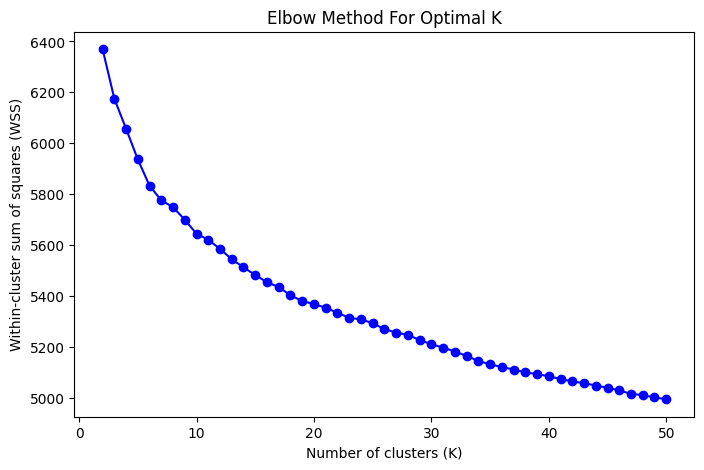

In [10]:
from sklearn.cluster import KMeans

# Compute WSS (Within-cluster sum of squares) for K=2 to 50
wss = []
K_range = range(2, 51)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings_train)
    wss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, wss, 'bo-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Within-cluster sum of squares (WSS)')
plt.title('Elbow Method For Optimal K')
plt.show()

/tmp/ipython-input-1828179168.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  ax1.plot(K_range, wss, 'bo-', color=color)
/tmp/ipython-input-1828179168.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  ax2.plot(K_range, silhouette_scores, 'ro-', color=color)


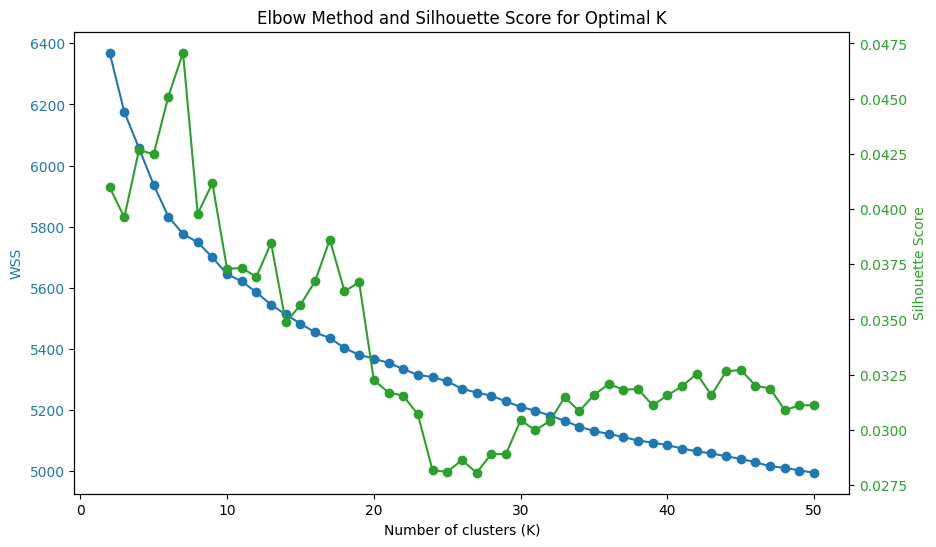

In [11]:
from sklearn.metrics import silhouette_score

wss = []
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings_train)
    wss.append(kmeans.inertia_)
    score = silhouette_score(embeddings_train, cluster_labels)
    silhouette_scores.append(score)

# Plot both WSS and silhouette scores
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Number of clusters (K)')
ax1.set_ylabel('WSS', color=color)
ax1.plot(K_range, wss, 'bo-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(K_range, silhouette_scores, 'ro-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Elbow Method and Silhouette Score for Optimal K')
plt.show()

In [12]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 76.6 MB/s eta 0:00:00


In [13]:
optimal_k = 5

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(embeddings_train)  # This step fits the model
train['Cluster'] = kmeans.labels_

/tmp/ipython-input-1426914489.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Cluster'] = kmeans.labels_


In [14]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import nltk
from nltk.corpus import stopwords
import re

# Download stopwords if not already done
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Preprocessing function to tokenize and clean text
def preprocess(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    tokens = [w for w in text.split() if w not in stop_words and len(w) > 2]
    return tokens

# Prepare tokenized documents per cluster
cluster_docs = []
num_clusters = train['Cluster'].nunique()
for c in range(num_clusters):
    titles = train[train['Cluster'] == c]['Title'].tolist()
    tokens = [preprocess(title) for title in titles]
    cluster_docs.append([word for doc in tokens for word in doc])  # flatten per cluster

# Create dictionary for all clusters
dictionary = Dictionary(cluster_docs)

# Compute coherence scores for each cluster ('c_v' coherence)
coherence_model = CoherenceModel(topics=cluster_docs, texts=cluster_docs, dictionary=dictionary, coherence='c_v')
coherence_scores = coherence_model.get_coherence_per_topic()

for i, score in enumerate(coherence_scores):
    print(f'Cluster {i} coherence score: {score:.4f}')

# Overall coherence score treating all clusters combined
all_tokens = [word for doc in cluster_docs for word in doc]
dictionary_all = Dictionary([all_tokens])
coherence_model_all = CoherenceModel(topics=[all_tokens], texts=[all_tokens], dictionary=dictionary_all, coherence='c_v')
overall_coherence_score = coherence_model_all.get_coherence()
print(f'Overall coherence score for all clusters combined: {overall_coherence_score:.4f}')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Cluster 0 coherence score: 0.5345
Cluster 1 coherence score: 0.4236
Cluster 2 coherence score: 0.5224
Cluster 3 coherence score: 0.5574
Cluster 4 coherence score: 0.4897
Overall coherence score for all clusters combined: 0.5354


Top 10 words in Cluster 0: [('sri', 162), ('flood', 148), ('lanka', 146), ('drought', 120), ('floods', 93), ('water', 92), ('affected', 91), ('relief', 82), ('weather', 82), ('landslide', 82)]


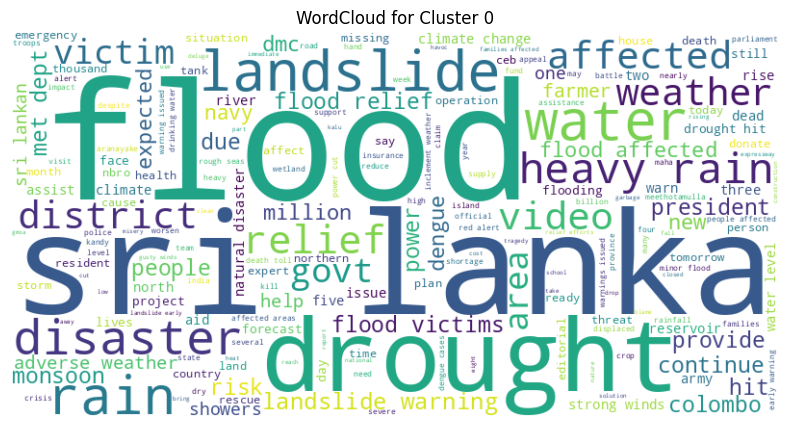

Top 10 words in Cluster 1: [('sri', 587), ('lanka', 566), ('crisis', 418), ('economic', 355), ('inflation', 223), ('govt', 177), ('imf', 126), ('bank', 97), ('debt', 85), ('economy', 80)]


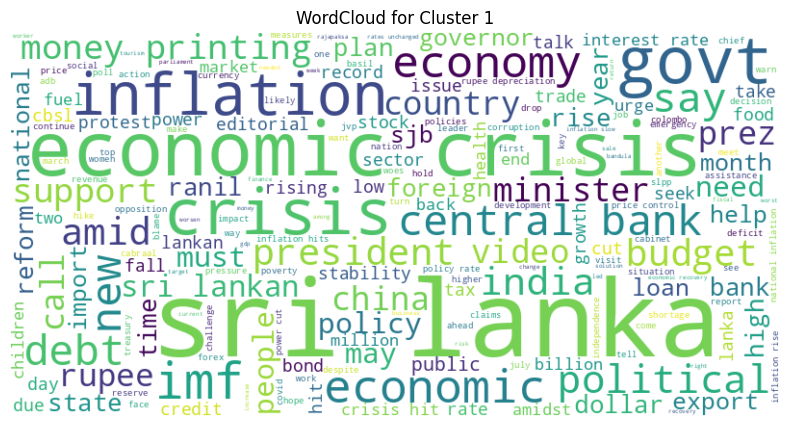

Top 10 words in Cluster 2: [('sri', 240), ('lanka', 208), ('christmas', 164), ('new', 105), ('year', 91), ('avurudu', 70), ('auction', 66), ('president', 52), ('govt', 51), ('video', 50)]


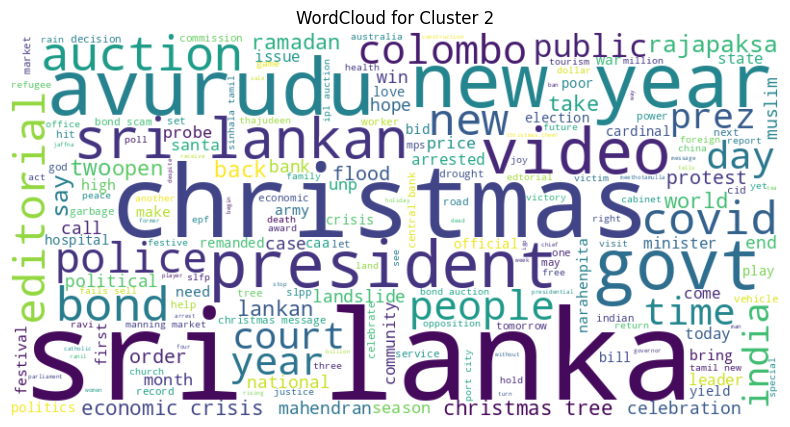

Top 10 words in Cluster 3: [('sri', 224), ('lanka', 216), ('price', 209), ('prices', 198), ('tea', 155), ('govt', 145), ('import', 127), ('rice', 121), ('ban', 93), ('farmers', 73)]


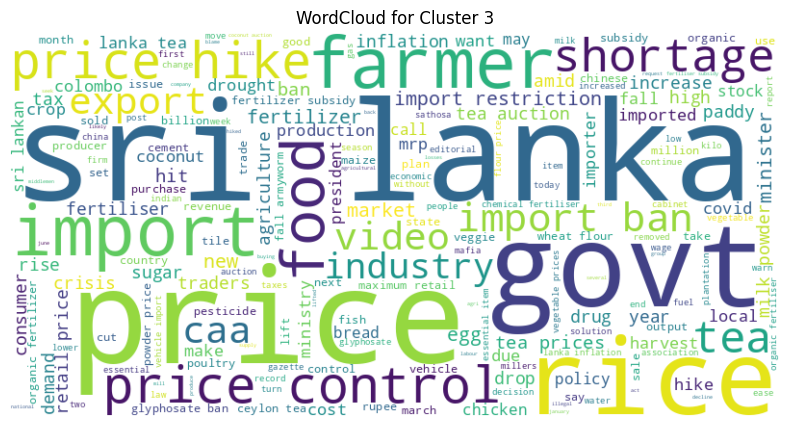

Top 10 words in Cluster 4: [('fuel', 453), ('power', 359), ('cuts', 196), ('price', 186), ('lanka', 175), ('sri', 161), ('ceb', 125), ('prices', 124), ('hike', 116), ('govt', 108)]


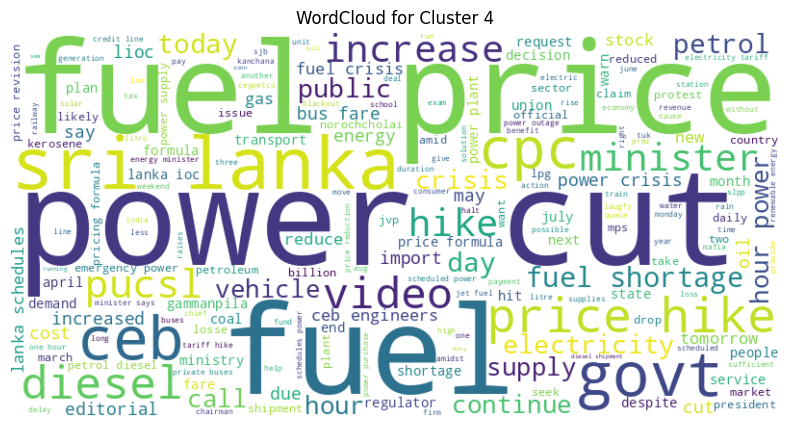

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Assuming df with 'Title' and 'Cluster' after K-means clustering
# Also assuming preprocess(text) defined as before to tokenize and clean

def generate_wordcloud(text, cluster_id):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for Cluster {cluster_id}')
    plt.show()

# Generate and display wordclouds for each cluster
num_clusters = train['Cluster'].nunique()
for c in range(num_clusters):
    titles = train[train['Cluster'] == c]['Title'].tolist()
    # Preprocess and flatten tokens into a single string
    tokens = [w for title in titles for w in preprocess(title)]
    text = ' '.join(tokens)
    print(f'Top 10 words in Cluster {c}:', Counter(tokens).most_common(10))
    generate_wordcloud(text, c)

In [21]:
# Specify number of clusters
num_clusters = 5
cluster_range = list(range(1, num_clusters + 1))

# Create a frequency table of clusters for each date
cluster_freq1 = pd.crosstab(train['Date'], train['Cluster'])

# Ensure all cluster columns are present before sorting
for c in cluster_range:
    if c not in cluster_freq1.columns:
        cluster_freq1[c] = 0

train_news = cluster_freq1[cluster_range]
train_news.reset_index(inplace=True)

# Run K-means clustering
test['Cluster'] = kmeans.predict(embeddings_test)

cluster_freq2 = pd.crosstab(test['Date'], test['Cluster'])

for c in cluster_range:
    if c not in cluster_freq2.columns:
        cluster_freq2[c] = 0

test_news = cluster_freq2[cluster_range]
test_news.reset_index(inplace=True)

train_news.to_csv('train_news.csv', index=False)
test_news.to_csv('test_news.csv', index=False)

combined_news = pd.concat([train_news, test_news], axis=0)

/tmp/ipython-input-3522008291.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Cluster'] = kmeans.predict(embeddings_test)


In [24]:
combined_news = pd.concat([train_news, test_news], axis=0)

combined_news.to_csv('/content/drive/My Drive/Research UG/codes/DataSet/news_market.csv', index=False)

combined_news.tail(100)


Cluster,Date,1,2,3,4,5
614,2025-05-24,0,1,0,0,0
615,2025-05-25,0,0,1,0,0
616,2025-05-26,0,1,2,0,0
617,2025-05-27,2,0,1,0,0
618,2025-05-28,1,0,0,0,0
...,...,...,...,...,...,...
709,2025-09-23,0,0,1,1,0
710,2025-09-24,0,0,1,0,0
711,2025-09-25,2,1,0,0,0
712,2025-09-27,0,1,0,0,0
